# Generating realistic flare profiles from the flare catalog

This notebook demonstrates the use of Kernel Density Estimation to draw realistic flare shapes from an input distribution. For this, we use the dimensionality reduced space of flare shapes, using Principal Component Analysis. This way, any number of different flare profiles can be sampled. An example use case is presented for creating a synthetic light curve with stellar flares. For more details, see Section 4.2 of the paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

In [2]:
flare_time = np.linspace(-3, 10, num=200)
flare_shapes = np.loadtxt('TESS_interpolated_flare_shapes.dat')
flare_catalog = pd.read_csv('Table3_flare_catalog.csv')

# Principal Component Analysis (PCA)

In [3]:
PCA_components = 5 # increase for more detailed, but also more noisy flares
X = np.array(flare_shapes)
pca = PCA(n_components=PCA_components).fit(X)
X_pca = pca.transform(X)

# Kernel Density Estimation (KDE)

In [4]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X_pca)
new_samples_pca = kde.sample(100000) # draw a random sample in PC space
new_samples = pca.inverse_transform(new_samples_pca) # transform back with the PCA basis

### Inspect a few flares

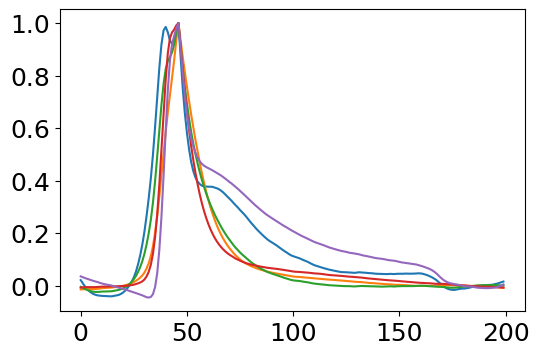

In [5]:
for i in np.random.choice(len(new_samples), 5):
    plt.plot(new_samples[i])

### Take a look at a 2 dimensional section of the PC space

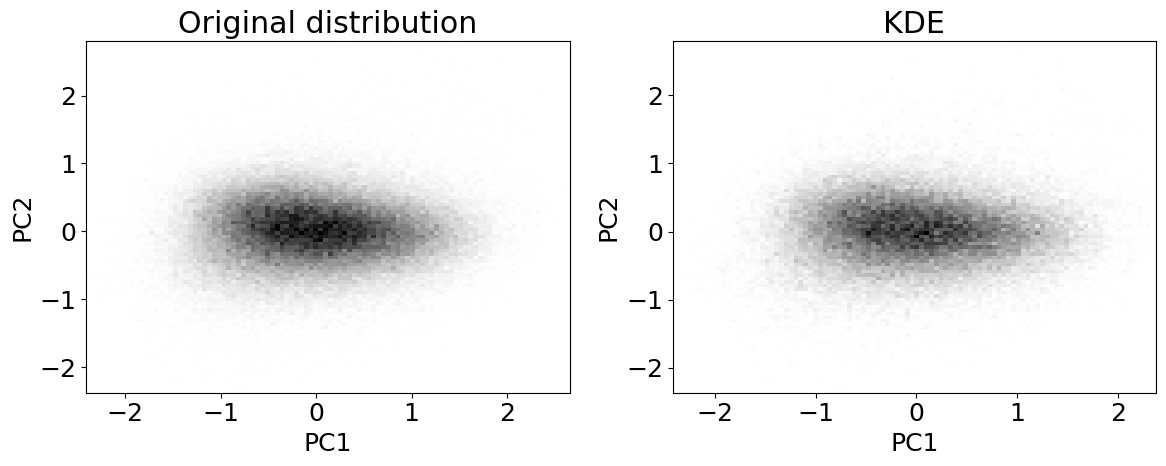

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Original distribution')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.hist2d(X_pca[:,0], X_pca[:,1], bins=100, cmap='gray_r');
plt.subplot(122)
plt.title('KDE')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.hist2d(new_samples_pca[:,0], new_samples_pca[:,1], bins=100, cmap='gray_r');
plt.tight_layout()

# Joint KDE for light curve simulation

In [7]:
X_for_kde = np.c_[np.log10(np.c_[flare_catalog[['amplitude', 'timescale']]]), X_pca] # add also the flare amplitude and time scale
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X_for_kde)

In [8]:
def generate_lc(period=10, num_flares=10, noise=0.005):
    t_sim = np.arange(0, 27, 2/24/60) # 27 day long TESS sector with 2 min cadence
    f_sim = 0.1 * np.sin(t_sim*2*np.pi/period) + np.random.normal(0, noise, len(t_sim)) # sinusoidal variation with noise
    w_flare = np.array([False] * len(t_sim))

    for i in range(num_flares):
        sample = kde.sample(1)[0]
        A, t_12 = 10**sample[:2] # transform the logarithms back
        t_12 /= 24 * 60 # convert minutes to days
        t_peak = np.random.uniform(np.min(t_sim), np.max(t_sim))
        t_temp, f_temp = t_peak + t_12 * flare_time, A * pca.inverse_transform([sample[2:]])[0]
        f_flare = np.interp(x=t_sim, xp=t_temp, fp=f_temp, left=0, right=0)
        f_sim += f_flare
        w_flare[f_flare != 0] = True # locate the flaring points
        
    return t_sim, f_sim, w_flare

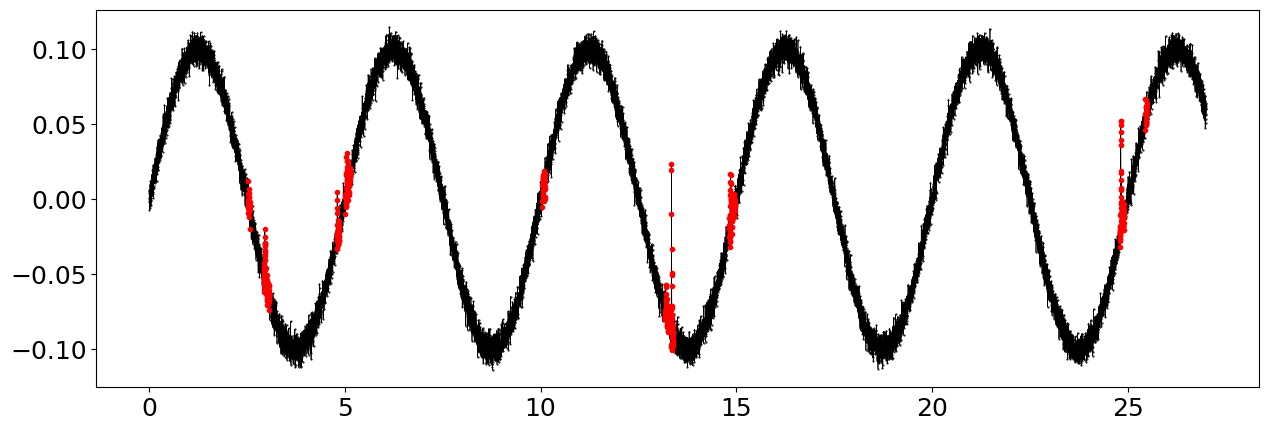

In [9]:
t_sim, f_sim, w_flare = generate_lc(period=5, num_flares=10, noise=0.005)

plt.figure(figsize=(15,5))
plt.plot(t_sim, f_sim, 'k.-', ms=1, lw=0.5)
plt.plot(t_sim[w_flare], f_sim[w_flare], 'r.')